# 📊 E-Commerce Clothing Classifier - Data Exploration

## Project Goal:
Build a deep learning model to automatically classify clothing items from images for:
- ✅ Automatic product tagging in e-commerce
- ✅ Improved search and recommendations
- ✅ Better inventory management

---

## In This Notebook:
1. Load and verify dataset structure
2. Explore images and segmentation masks
3. Analyze captions and labels
4. Understand the 24 clothing categories
5. Visualize data distribution

**Run each cell step by step!**

## Step 1: Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import json
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✅ All libraries imported successfully!")
print(f"   • NumPy version: {np.__version__}")
print(f"   • Pandas version: {pd.__version__}")
print(f"   • Matplotlib version: {plt.matplotlib.__version__}")

✅ All libraries imported successfully!
   • NumPy version: 1.26.4
   • Pandas version: 2.2.2
   • Matplotlib version: 3.9.2


## Step 2: Configure Dataset Paths

In [3]:
# Main dataset directory
DATASET_ROOT = r"C:\Users\My PC\Documents\clothing_classifier\dataset"

# Subdirectories and files
IMAGES_PATH = os.path.join(DATASET_ROOT, "images")
SEGM_PATH = os.path.join(DATASET_ROOT, "segm")
CAPTIONS_FILE = os.path.join(DATASET_ROOT, "captions.json")  # CORRECTED: Added .json extension
LABELS_PATH = os.path.join(DATASET_ROOT, "labels")
KEYPOINTS_PATH = os.path.join(DATASET_ROOT, "keypoints")

print("=" * 70)
print("DATASET CONFIGURATION")
print("=" * 70)
print(f"Root Directory : {DATASET_ROOT}")
print(f"Images folder  : {IMAGES_PATH}")
print(f"Segmentation   : {SEGM_PATH}")
print(f"Captions JSON  : {CAPTIONS_FILE}")
print(f"Labels folder  : {LABELS_PATH}")
print(f"Keypoints      : {KEYPOINTS_PATH}")
print("=" * 70)

DATASET CONFIGURATION
Root Directory : C:\Users\My PC\Documents\clothing_classifier\dataset
Images folder  : C:\Users\My PC\Documents\clothing_classifier\dataset\images
Segmentation   : C:\Users\My PC\Documents\clothing_classifier\dataset\segm
Captions JSON  : C:\Users\My PC\Documents\clothing_classifier\dataset\captions.json
Labels folder  : C:\Users\My PC\Documents\clothing_classifier\dataset\labels
Keypoints      : C:\Users\My PC\Documents\clothing_classifier\dataset\keypoints


## Step 3: Verify Dataset Structure

In [5]:
def verify_path(path, name):
    """Verify if path exists and count items"""
    exists = os.path.exists(path)
    
    if exists:
        if os.path.isdir(path):
            count = len(os.listdir(path))
            print(f"✅ {name:20s} : Found ({count:,} items)")
        else:
            size_kb = os.path.getsize(path) / 1024
            print(f"✅ {name:20s} : Found ({size_kb:.1f} KB)")
            count = 1
    else:
        print(f"❌ {name:20s} : Not found")
        count = 0
    
    return exists, count

print("\nVerifying Dataset Components:")
print("=" * 70)

# Verify all components
components = [
    (IMAGES_PATH, "Images Folder"),
    (SEGM_PATH, "Segmentation Folder"),
    (CAPTIONS_FILE, "Captions JSON"),
    (LABELS_PATH, "Labels Folder"),
    (KEYPOINTS_PATH, "Keypoints Folder")
]

verification_results = {}
for path, name in components:
    exists, count = verify_path(path, name)
    verification_results[name] = {'exists': exists, 'count': count}

print("=" * 70)


Verifying Dataset Components:
✅ Images Folder        : Found (44,096 items)
✅ Segmentation Folder  : Found (12,701 items)
✅ Captions JSON        : Found (11688.3 KB)
✅ Labels Folder        : Found (2 items)
✅ Keypoints Folder     : Found (2 items)


## Step 4: Load Image Files

In [7]:
# Get all image files
if os.path.exists(IMAGES_PATH):
    image_files = sorted([f for f in os.listdir(IMAGES_PATH) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    
    print(f"\n📸 Total Images Found: {len(image_files):,}")
    print("\nSample Image Filenames:")
    print("-" * 70)
    for i, img_name in enumerate(image_files[:5], 1):
        print(f"  {i}. {img_name}")
    print("-" * 70)
else:
    image_files = []
    print("\n❌ ERROR: Images folder not found!")


📸 Total Images Found: 44,096

Sample Image Filenames:
----------------------------------------------------------------------
  1. MEN-Denim-id_00000080-01_7_additional.jpg
  2. MEN-Denim-id_00000089-01_7_additional.jpg
  3. MEN-Denim-id_00000089-02_7_additional.jpg
  4. MEN-Denim-id_00000089-03_7_additional.jpg
  5. MEN-Denim-id_00000089-04_7_additional.jpg
----------------------------------------------------------------------


## Step 5: Load Segmentation Files and Create Mapping

In [9]:
# Get all segmentation files
if os.path.exists(SEGM_PATH):
    segm_files = sorted(os.listdir(SEGM_PATH))
    
    print(f"\n🎨 Total Segmentation Masks Found: {len(segm_files):,}")
    print("\nSample Segmentation Filenames:")
    print("-" * 70)
    for i, seg_name in enumerate(segm_files[:5], 1):
        print(f"  {i}. {seg_name}")
    print("-" * 70)
    
    # CORRECTED MAPPING LOGIC
    # Image:  MEN-Denim-id_00000080-01_7_additional.jpg
    # Segm:   MEN-Denim-id_00000080-01_7_additional_segm.png
    # Strategy: Remove extension from image name, then check if corresponding _segm file exists
    
    segm_mapping = {}  # Maps image_name -> segmentation_filename
    
    for img_file in image_files:
        # Remove extension to get base name
        img_base = os.path.splitext(img_file)[0]  # e.g., MEN-Denim-id_00000080-01_7_additional
        
        # Expected segmentation filename
        expected_segm = img_base + "_segm.png"
        
        # Check if this segmentation file exists
        if expected_segm in segm_files:
            segm_mapping[img_file] = expected_segm
    
    print(f"\n✅ Created mapping for {len(segm_mapping):,} image-segmentation pairs")
    
    # Check coverage
    coverage_pct = (len(segm_mapping) / len(image_files) * 100) if len(image_files) > 0 else 0
    
    print(f"📊 Images with segmentation masks: {len(segm_mapping):,} / {len(image_files):,}")
    print(f"   Coverage: {coverage_pct:.1f}%")
    
    # Show a few examples of the mapping
    if len(segm_mapping) > 0:
        print("\nExample Mappings:")
        print("-" * 70)
        for i, (img, segm) in enumerate(list(segm_mapping.items())[:3], 1):
            print(f"  {i}. Image: {img}")
            print(f"     Segm : {segm}")
        print("-" * 70)
else:
    segm_files = []
    segm_mapping = {}
    print("\n❌ ERROR: Segmentation folder not found!")


🎨 Total Segmentation Masks Found: 12,701

Sample Segmentation Filenames:
----------------------------------------------------------------------
  1. MEN-Denim-id_00000080-01_7_additional_segm.png
  2. MEN-Denim-id_00000089-01_7_additional_segm.png
  3. MEN-Denim-id_00000089-02_7_additional_segm.png
  4. MEN-Denim-id_00000089-03_7_additional_segm.png
  5. MEN-Denim-id_00000089-04_7_additional_segm.png
----------------------------------------------------------------------

✅ Created mapping for 12,701 image-segmentation pairs
📊 Images with segmentation masks: 12,701 / 44,096
   Coverage: 28.8%

Example Mappings:
----------------------------------------------------------------------
  1. Image: MEN-Denim-id_00000080-01_7_additional.jpg
     Segm : MEN-Denim-id_00000080-01_7_additional_segm.png
  2. Image: MEN-Denim-id_00000089-01_7_additional.jpg
     Segm : MEN-Denim-id_00000089-01_7_additional_segm.png
  3. Image: MEN-Denim-id_00000089-02_7_additional.jpg
     Segm : MEN-Denim-id_00000

## Step 6: Load Captions from JSON File

In [10]:
# Load captions JSON file
captions_dict = {}

if os.path.exists(CAPTIONS_FILE):
    try:
        with open(CAPTIONS_FILE, 'r', encoding='utf-8') as f:
            captions_dict = json.load(f)
        
        print(f"\n📝 Captions Loaded Successfully!")
        print(f"   Total captions: {len(captions_dict):,}")
        
        # Show sample captions
        print("\nSample Captions:")
        print("=" * 70)
        for i, (img_name, caption) in enumerate(list(captions_dict.items())[:3], 1):
            print(f"\n{i}. Image: {img_name}")
            print(f"   Caption: {caption[:200]}...")  # Show first 200 chars
        print("=" * 70)
        
    except json.JSONDecodeError as e:
        print(f"\n❌ ERROR: Failed to parse JSON file: {e}")
    except Exception as e:
        print(f"\n❌ ERROR: Failed to load captions: {e}")
else:
    print(f"\n❌ ERROR: Captions file not found at: {CAPTIONS_FILE}")


📝 Captions Loaded Successfully!
   Total captions: 42,544

Sample Captions:

1. Image: MEN-Denim-id_00000080-01_7_additional.jpg
   Caption: The lower clothing is of long length. The fabric is cotton and it has plaid patterns....

2. Image: MEN-Denim-id_00000089-01_7_additional.jpg
   Caption: His tank top has sleeves cut off, cotton fabric and pure color patterns. The neckline of it is round. The pants this man wears is of long length. The pants are with cotton fabric and pure color patter...

3. Image: MEN-Denim-id_00000089-02_7_additional.jpg
   Caption: His sweater has long sleeves, cotton fabric and stripe patterns. The neckline of it is lapel. The gentleman wears a long pants. The pants are with cotton fabric and solid color patterns....


## Step 7: Define 24 Clothing Categories

In [14]:
# 24 Clothing categories from DeepFashion-MultiModal dataset
CLOTHING_LABELS = {
    0: 'background',
    1: 'top',
    2: 'outer',
    3: 'skirt',
    4: 'dress',
    5: 'pants',
    6: 'leggings',
    7: 'headwear',
    8: 'eyeglass',
    9: 'neckwear',
    10: 'belt',
    11: 'footwear',
    12: 'bag',
    13: 'hair',
    14: 'face',
    15: 'skin',
    16: 'ring',
    17: 'wrist wearing',
    18: 'socks',
    19: 'gloves',
    20: 'necklace',
    21: 'rompers',
    22: 'earrings',
    23: 'tie'
}

# Main clothing categories for classification (excluding body parts and accessories)
MAIN_CLOTHING_CATEGORIES = {
    1: 'top',
    2: 'outer',
    3: 'skirt',
    4: 'dress',
    5: 'pants',
    6: 'leggings',
    11: 'footwear',
    12: 'bag',
    21: 'rompers'
}

print("\n" + "=" * 70)
print("24 CLOTHING CATEGORIES")
print("=" * 70)

for idx in range(0, 24, 4):
    row_items = []
    for i in range(idx, min(idx + 4, 24)):
        row_items.append(f"{i:2d}: {CLOTHING_LABELS[i]:15s}")
    print("  ".join(row_items))

print("=" * 70)
print("\n✨ Main Clothing Categories for Classification:")
print("-" * 70)
for idx, label in MAIN_CLOTHING_CATEGORIES.items():
    print(f"  {idx:2d}: {label.upper()}")
print("-" * 70)


24 CLOTHING CATEGORIES
 0: background        1: top               2: outer             3: skirt          
 4: dress             5: pants             6: leggings          7: headwear       
 8: eyeglass          9: neckwear         10: belt             11: footwear       
12: bag              13: hair             14: face             15: skin           
16: ring             17: wrist wearing    18: socks            19: gloves         
20: necklace         21: rompers          22: earrings         23: tie            

✨ Main Clothing Categories for Classification:
----------------------------------------------------------------------
   1: TOP
   2: OUTER
   3: SKIRT
   4: DRESS
   5: PANTS
   6: LEGGINGS
  11: FOOTWEAR
  12: BAG
  21: ROMPERS
----------------------------------------------------------------------


## Step 8: Visualize Sample Images


🖼️ Displaying 6 Random Sample Images:



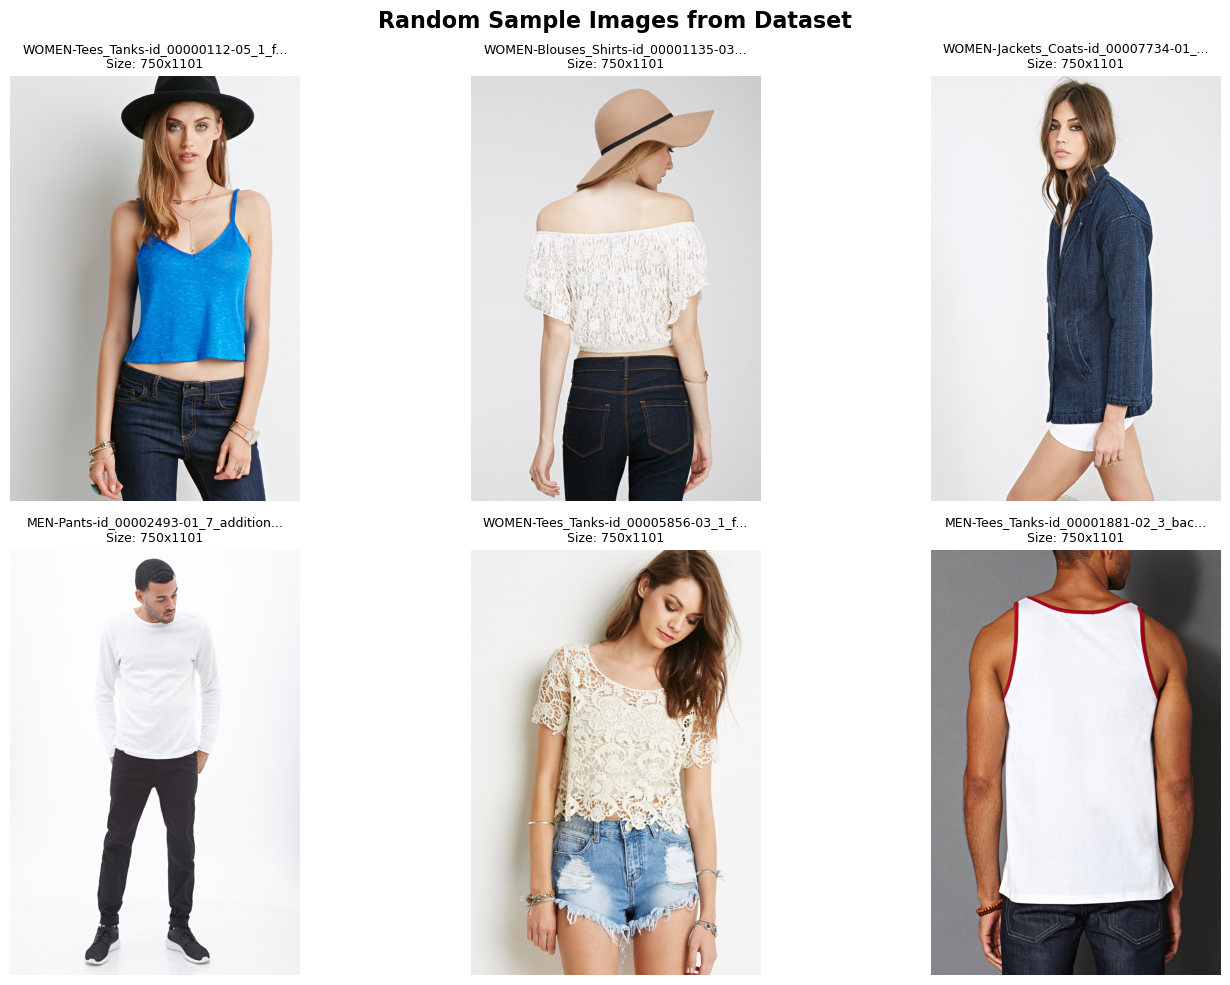

In [16]:
def display_sample_images(num_samples=6):
    """Display random sample images in a grid"""
    
    if len(image_files) == 0:
        print("❌ No images found!")
        return
    
    # Select random images
    sample_images = np.random.choice(image_files, 
                                    min(num_samples, len(image_files)), 
                                    replace=False)
    
    # Create grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, img_name in enumerate(sample_images):
        img_path = os.path.join(IMAGES_PATH, img_name)
        
        try:
            img = Image.open(img_path)
            axes[idx].imshow(img)
            
            # Add title with image name and size
            title = f"{img_name[:35]}...\nSize: {img.size[0]}x{img.size[1]}"
            axes[idx].set_title(title, fontsize=9)
            axes[idx].axis('off')
            
        except Exception as e:
            axes[idx].text(0.5, 0.5, f"Error loading\n{img_name}", 
                          ha='center', va='center', fontsize=10)
            axes[idx].axis('off')
    
    plt.suptitle('Random Sample Images from Dataset', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Display sample images
print("\n🖼️ Displaying 6 Random Sample Images:\n")
display_sample_images(6)

## Step 9: Visualize Image with Segmentation Mask and Caption


🎨 VISUALIZING COMPLETE SAMPLES (Image + Segmentation + Caption)


SAMPLE #1


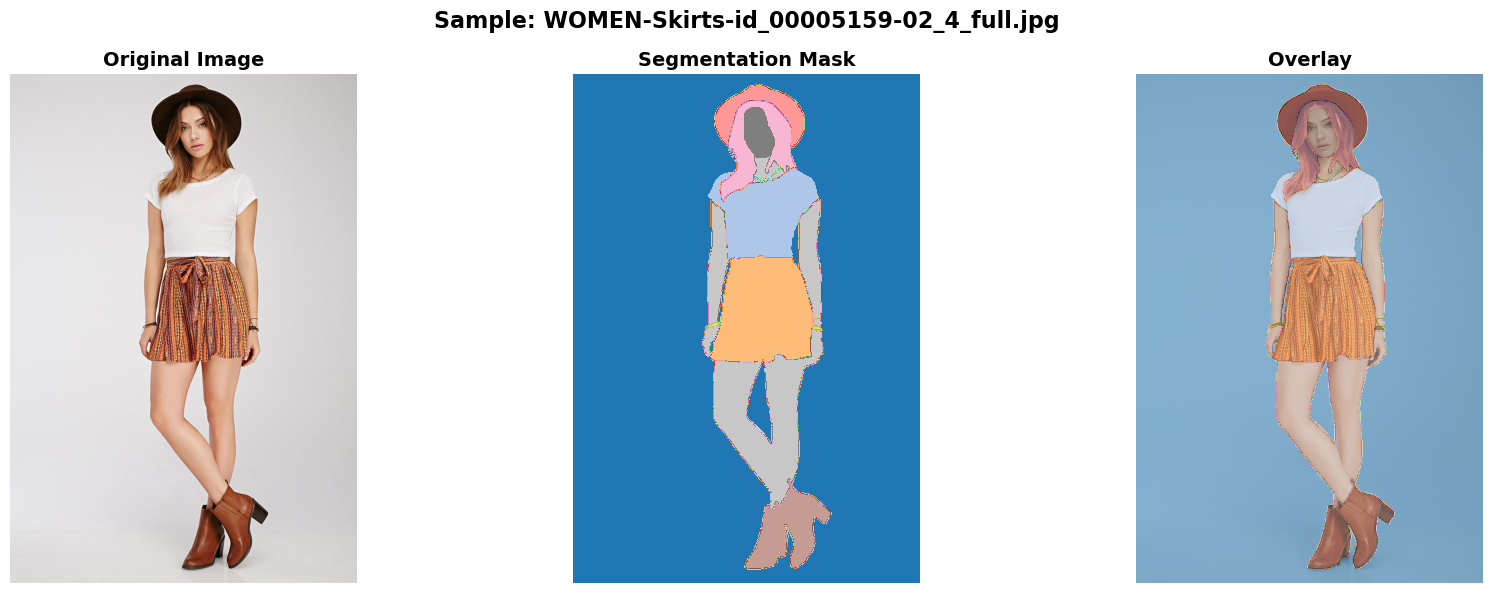


IMAGE: WOMEN-Skirts-id_00005159-02_4_full.jpg

🏷️ Clothing Items Detected:
  • background
  ✨ TOP (Main Category)
  ✨ SKIRT (Main Category)
  • headwear
  ✨ FOOTWEAR (Main Category)
  • hair
  • face
  • skin
  • wrist wearing
  • necklace

📝 Caption:
   The person is wearing a short-sleeve T-shirt with solid color patterns and a three-point skirt. The T-shirt is with cotton fabric and its neckline is round. The skirt is with cotton fabric and graphic patterns. The person wears a belt. There is an accessory in his her neck. The female wears a hat. There is an accessory on her wrist.


SAMPLE #2


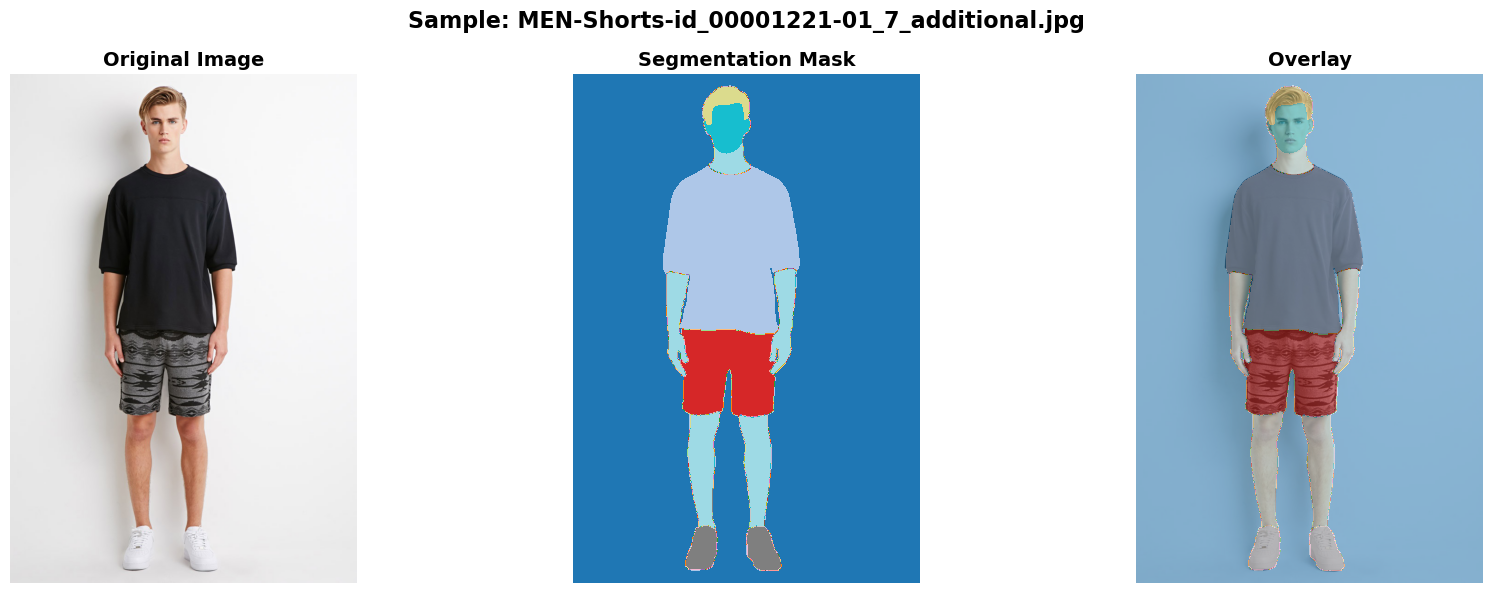


IMAGE: MEN-Shorts-id_00001221-01_7_additional.jpg

🏷️ Clothing Items Detected:
  • background
  ✨ TOP (Main Category)
  ✨ PANTS (Main Category)
  ✨ FOOTWEAR (Main Category)
  • hair
  • face
  • skin

📝 Caption:
   The person is wearing a short-sleeve T-shirt with solid color patterns. The T-shirt is with cotton fabric and its neckline is round. The pants the person wears is of short length. The pants are with cotton fabric and graphic patterns.


SAMPLE #3


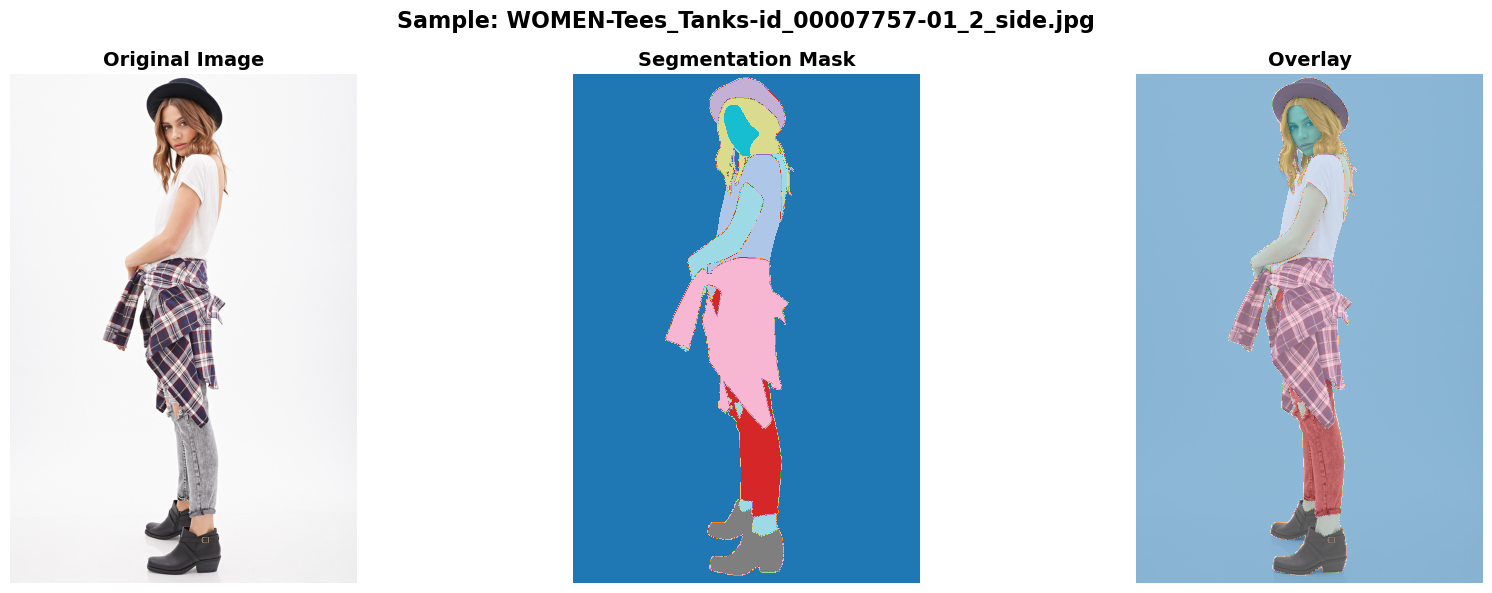


IMAGE: WOMEN-Tees_Tanks-id_00007757-01_2_side.jpg

🏷️ Clothing Items Detected:
  • background
  ✨ TOP (Main Category)
  ✨ PANTS (Main Category)
  • headwear
  • belt
  ✨ FOOTWEAR (Main Category)
  • hair
  • face
  • skin

📝 Caption:
   The T-shirt the female wears has short sleeves and it is with cotton fabric and solid color patterns. The female wears a long trousers, with denim fabric and solid color patterns. There is clothing on her waist. The person has a hat in her head.



In [18]:
def visualize_complete_sample(image_name=None):
    """Visualize image with segmentation mask and caption"""
    
    # Select random image with segmentation
    if image_name is None:
        images_with_segm = list(segm_mapping.keys())
        
        if not images_with_segm:
            print("❌ No images with segmentation found!")
            return
        
        image_name = np.random.choice(images_with_segm)
    
    # Get paths
    img_path = os.path.join(IMAGES_PATH, image_name)
    seg_filename = segm_mapping.get(image_name)
    seg_path = os.path.join(SEGM_PATH, seg_filename) if seg_filename else None
    
    if not os.path.exists(img_path):
        print(f"❌ Image not found: {img_path}")
        return
    
    # Load image
    img = Image.open(img_path)
    
    # Check if segmentation exists
    if seg_path and os.path.exists(seg_path):
        try:
            # Load segmentation
            seg = Image.open(seg_path)
            seg_array = np.array(seg)
            
            # Create 3-panel visualization
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            # Panel 1: Original image
            axes[0].imshow(img)
            axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
            axes[0].axis('off')
            
            # Panel 2: Segmentation mask
            axes[1].imshow(seg_array, cmap='tab20')
            axes[1].set_title("Segmentation Mask", fontsize=14, fontweight='bold')
            axes[1].axis('off')
            
            # Panel 3: Overlay
            axes[2].imshow(img)
            axes[2].imshow(seg_array, alpha=0.5, cmap='tab20')
            axes[2].set_title("Overlay", fontsize=14, fontweight='bold')
            axes[2].axis('off')
            
            plt.suptitle(f'Sample: {image_name[:50]}', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            # Analyze segmentation
            unique_labels = np.unique(seg_array)
            
            print("\n" + "=" * 70)
            print(f"IMAGE: {image_name}")
            print("=" * 70)
            
            print("\n🏷️ Clothing Items Detected:")
            for label in unique_labels:
                if label in CLOTHING_LABELS:
                    category = CLOTHING_LABELS[label]
                    if label in MAIN_CLOTHING_CATEGORIES:
                        print(f"  ✨ {category.upper()} (Main Category)")
                    else:
                        print(f"  • {category}")
            
        except Exception as e:
            print(f"❌ Error loading segmentation: {e}")
            # Show only image
            fig, ax = plt.subplots(1, 1, figsize=(8, 10))
            ax.imshow(img)
            ax.set_title(f"Image: {image_name}", fontsize=14, fontweight='bold')
            ax.axis('off')
            plt.show()
    else:
        print(f"⚠️ No segmentation mask found for: {image_name}")
        # Show only image
        fig, ax = plt.subplots(1, 1, figsize=(8, 10))
        ax.imshow(img)
        ax.set_title(f"Image: {image_name}", fontsize=14, fontweight='bold')
        ax.axis('off')
        plt.show()
    
    # Show caption if available
    if image_name in captions_dict:
        print(f"\n📝 Caption:")
        print(f"   {captions_dict[image_name]}")
    else:
        print(f"\n⚠️ No caption found for this image")
    
    print("=" * 70)

# Visualize multiple complete samples
print("\n🎨 VISUALIZING COMPLETE SAMPLES (Image + Segmentation + Caption)\n")
for i in range(3):
    print(f"\n{'='*70}")
    print(f"SAMPLE #{i+1}")
    print(f"{'='*70}")
    visualize_complete_sample()
    print()

## Step 10: Analyze Category Distribution


📊 Analyzing category distribution from 500 segmentation masks...

✅ Successfully analyzed 500 images

CATEGORY DISTRIBUTION
     Category  Frequency  Percentage
   background        500       11.13
         skin        500       11.13
         face        499       11.11
         hair        498       11.09
     footwear        496       11.04
          top        347        7.72
         ring        324        7.21
        pants        306        6.81
wrist wearing        231        5.14
     necklace        154        3.43
        outer        134        2.98
        dress        118        2.63
     headwear         70        1.56
     earrings         67        1.49
          bag         57        1.27
        skirt         52        1.16
        socks         42        0.93
         belt         30        0.67
      rompers         28        0.62
     eyeglass         25        0.56
     leggings         11        0.24
     neckwear          3        0.07


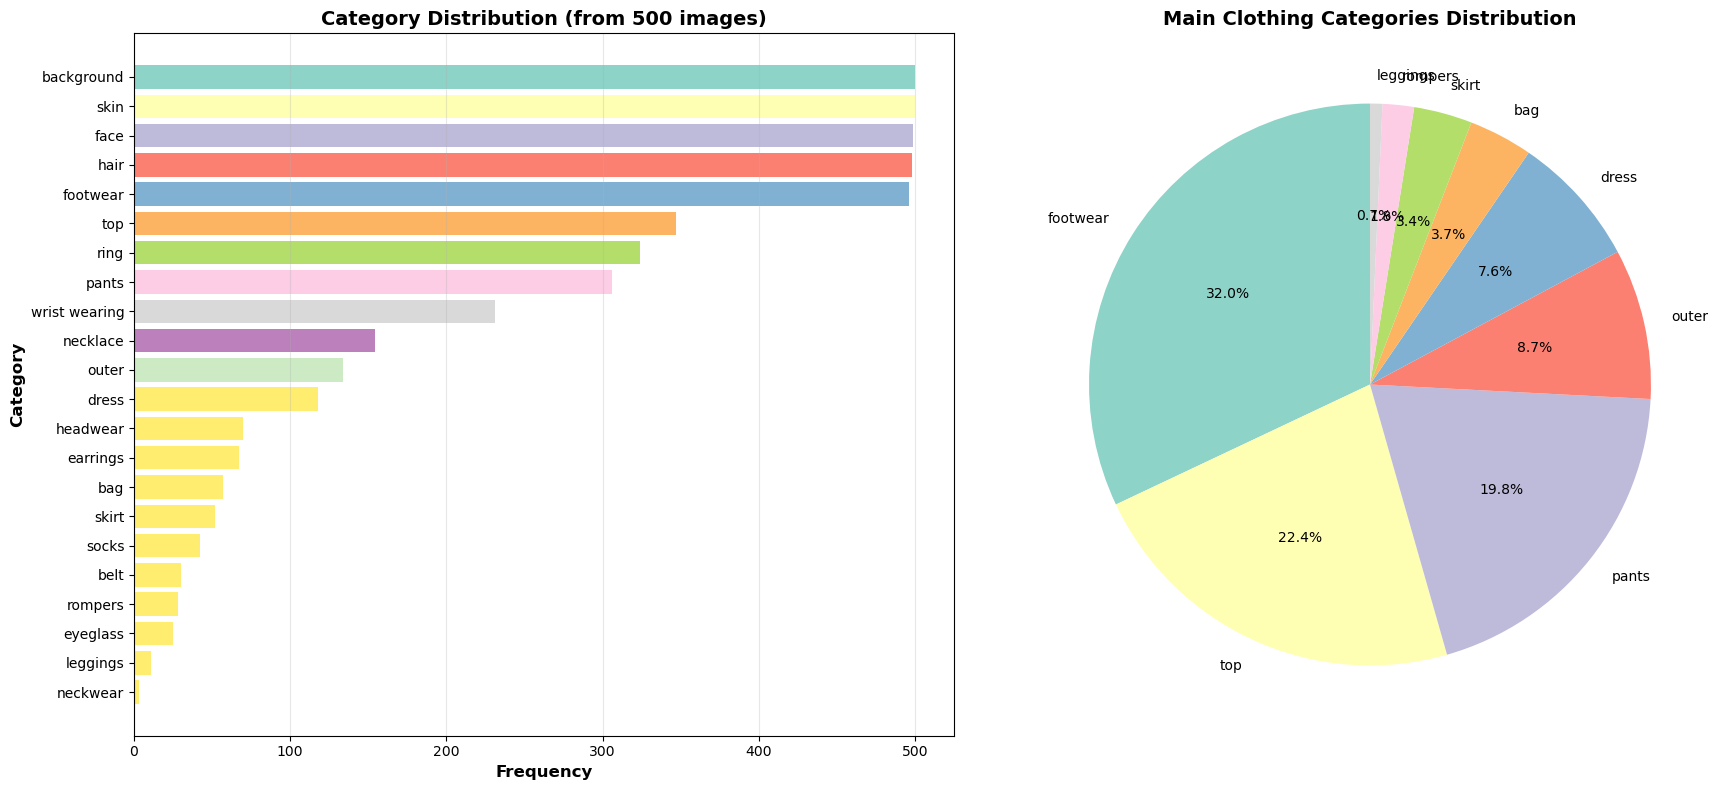

In [20]:
def analyze_category_distribution(num_samples=500):
    """Analyze which clothing categories appear most frequently"""
    
    print(f"\n📊 Analyzing category distribution from {num_samples} segmentation masks...\n")
    
    # Get images with segmentation
    images_with_segm = list(segm_mapping.keys())
    
    if not images_with_segm:
        print("❌ No images with segmentation found!")
        return None
    
    # Sample random images
    sample_size = min(num_samples, len(images_with_segm))
    sample_images = np.random.choice(images_with_segm, sample_size, replace=False)
    
    # Count categories
    category_counts = Counter()
    processed = 0
    
    for img_name in sample_images:
        seg_filename = segm_mapping[img_name]
        seg_path = os.path.join(SEGM_PATH, seg_filename)
        
        if os.path.exists(seg_path):
            try:
                seg = Image.open(seg_path)
                seg_array = np.array(seg)
                unique_labels = np.unique(seg_array)
                
                for label in unique_labels:
                    if label in CLOTHING_LABELS:
                        category_counts[CLOTHING_LABELS[label]] += 1
                
                processed += 1
            except:
                continue
    
    print(f"✅ Successfully analyzed {processed} images\n")
    
    # Create DataFrame
    df = pd.DataFrame(list(category_counts.items()), 
                     columns=['Category', 'Frequency'])
    df = df.sort_values('Frequency', ascending=False).reset_index(drop=True)
    
    # Add percentage
    df['Percentage'] = (df['Frequency'] / df['Frequency'].sum() * 100).round(2)
    
    # Display results
    print("=" * 70)
    print("CATEGORY DISTRIBUTION")
    print("=" * 70)
    print(df.to_string(index=False))
    print("=" * 70)
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Bar chart
    colors = plt.cm.Set3(range(len(df)))
    ax1.barh(df['Category'], df['Frequency'], color=colors)
    ax1.set_xlabel('Frequency', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Category', fontsize=12, fontweight='bold')
    ax1.set_title(f'Category Distribution (from {processed} images)', 
                  fontsize=14, fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)
    
    # Pie chart for main clothing categories
    main_cat_data = df[df['Category'].isin(MAIN_CLOTHING_CATEGORIES.values())]
    if len(main_cat_data) > 0:
        ax2.pie(main_cat_data['Frequency'], labels=main_cat_data['Category'], 
                autopct='%1.1f%%', startangle=90, colors=colors[:len(main_cat_data)])
        ax2.set_title('Main Clothing Categories Distribution', 
                      fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return df

# Run analysis
category_df = analyze_category_distribution(num_samples=500)

## Step 11: Complete Dataset Summary

In [22]:
# Generate complete summary
print("\n" + "=" * 70)
print("COMPLETE DATASET SUMMARY")
print("=" * 70)

summary_data = {
    'Component': [
        'Total Images',
        'Segmentation Masks',
        'Images with Segmentation',
        'Captions (Text Descriptions)',
        'Total Clothing Categories',
        'Main Clothing Categories'
    ],
    'Count': [
        f"{len(image_files):,}",
        f"{len(segm_files):,}",
        f"{len(segm_mapping):,}",
        f"{len(captions_dict):,}",
        "24",
        "9"
    ],
    'Status': ['✅'] * 6
}

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))
print("\n" + "=" * 70)

# Key insights
coverage_pct = (len(segm_mapping) / len(image_files) * 100) if len(image_files) > 0 else 0

print("\n💡 KEY INSIGHTS:")
print("-" * 70)
print(f"  • Dataset contains {len(image_files):,} high-quality clothing images")
print(f"  • {len(segm_files):,} segmentation masks available")
print(f"  • {len(segm_mapping):,} images successfully matched with segmentation")
print(f"  • Coverage: {coverage_pct:.1f}% of images have segmentation masks")
print(f"  • {len(captions_dict):,} images have descriptive text captions")
print(f"  • 24 different categories can be identified from segmentation")
print(f"  • 9 main clothing categories for classification:")
for idx, cat in MAIN_CLOTHING_CATEGORIES.items():
    print(f"      - {cat.capitalize()}")
print("-" * 70)

if len(segm_mapping) > 0:
    print("\n✅ DATASET IS READY FOR MODEL TRAINING!")
else:
    print("\n⚠️ WARNING: No image-segmentation pairs found! Check file naming.")
    
print("=" * 70)


COMPLETE DATASET SUMMARY

                   Component  Count Status
                Total Images 44,096      ✅
          Segmentation Masks 12,701      ✅
    Images with Segmentation 12,701      ✅
Captions (Text Descriptions) 42,544      ✅
   Total Clothing Categories     24      ✅
    Main Clothing Categories      9      ✅


💡 KEY INSIGHTS:
----------------------------------------------------------------------
  • Dataset contains 44,096 high-quality clothing images
  • 12,701 segmentation masks available
  • 12,701 images successfully matched with segmentation
  • Coverage: 28.8% of images have segmentation masks
  • 42,544 images have descriptive text captions
  • 24 different categories can be identified from segmentation
  • 9 main clothing categories for classification:
      - Top
      - Outer
      - Skirt
      - Dress
      - Pants
      - Leggings
      - Footwear
      - Bag
      - Rompers
----------------------------------------------------------------------

✅ DATASET

## 🎯 Conclusions and Next Steps

### What We Learned:
1. ✅ Dataset structure verified and loaded successfully
2. ✅ Image-segmentation pairs mapped correctly
3. ✅ Captions loaded from JSON file
4. ✅ 24 clothing categories identified
5. ✅ 9 main categories selected for classification

### For E-Commerce Application:
- **Automatic Tagging**: Upload product → Model predicts category → Auto-tag
- **Smart Search**: Users search "dresses" → Show all dress products
- **Inventory Management**: Track products by category automatically

---

## 📋 Next Steps:

1. **Data Preprocessing** (Next Notebook)
   - Extract labels from segmentation masks
   - Identify dominant clothing category for each image
   - Resize images to 224×224
   - Create train/validation/test splits (70/15/15)
   - Normalize pixel values
   - Set up data augmentation

2. **Model Building**
   - Use transfer learning (ResNet50 or EfficientNet)
   - Configure for 9-class classification
   - Set up training callbacks

3. **Training & Evaluation**
   - Train the model
   - Monitor metrics
   - Test on held-out data
   - Generate confusion matrix

4. **Deployment & Demo**
   - Create testing notebook with upload widget
   - Build Streamlit dashboard
   - Demonstrate to professor

---

**Ready to proceed to Data Preprocessing? 🚀**